In [1]:
import numpy as np
import pandas as pd
import polars as pl

import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import util

In [2]:
RANDOM_SEED = 42

READ_ORIGINS = "/storage2/tbrekalo/HG002-simulated/chr19-read-origins.csv"
REF_MAP_PATH = "/storage2/tbrekalo/HG002-simulated/chr19-ref.paf"
CHAINS_PATH = "/home/tbrekalo/dev/tb-ram/dev-data/HG002/chr19-sim-sample-ava-chain.tsv"

In [3]:
df_origins = util.load_origins_df(READ_ORIGINS)
df_chains = util.load_chains_df(CHAINS_PATH)

In [4]:
df_chain_ovlp_labels = util.calc_ava_origin_overlap(
    util.expand_ava_with_origin_info(
        util.create_overlaps_from_chains(df_chains),
        df_origins,
    )
).select(
    pl.col("chain-id"),
    pl.col("query-start"),
    pl.col("query-end"),
    pl.col("target-start"),
    pl.col("target-end"),
    ((pl.col("ratio") > 0.875) & pl.col("matching-strands"))
    .cast(pl.Int64)
    .alias("label"),
)

In [5]:
df_features_pl = (
    df_chains.join(
        df_chain_ovlp_labels,
        on="chain-id",
    )
    .with_columns(pl.when(pl.col("strand") == "+").then(1).otherwise(1).alias("strand"))
    .group_by(
        "chain-id",
        maintain_order=True,
    )
    .agg(
        pl.col("query-match").diff().mean().alias("diff-mean"),
        *[
            pl.col("query-match")
            .diff()
            .quantile(q / 100, interpolation="lower")
            .alias(f"query-match-diff-q{q}")
            for q in [75, 85, 90, 95, 98]
        ],
        (pl.col("query-end") - pl.col("query-start"))
        .first()
        .alias("query-overlap-length"),
        (pl.col("target-end") - pl.col("target-start"))
        .first()
        .alias("target-overlap-length"),
        pl.col("query-matches").first(),
        pl.col("target-matches").first(),
        pl.col("label").first(),
    )
).select(
    [
        "diff-mean",
        *[f"query-match-diff-q{q}" for q in [75, 90, 95, 98]],
        "query-overlap-length",
        "query-matches",
        "target-overlap-length",
        "target-matches",
        "label",
    ]
)

In [6]:
df_features = df_features_pl.top_k(4_000, by="label").to_pandas()

In [7]:
df_features.shape

(4000, 10)

<Axes: xlabel='label', ylabel='Count'>

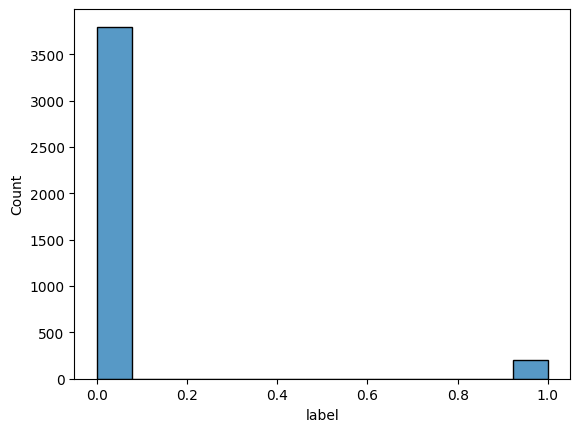

In [8]:
sns.histplot(df_features, x="label")

In [9]:
df_features.head(5)

,diff-mean,query-match-diff-q75,query-match-diff-q90,query-match-diff-q95,query-match-diff-q98,query-overlap-length,query-matches,target-overlap-length,target-matches,label
0,35.791667,33.0,53.0,61.0,83.0,859,173,1050,180,1
1,3.852743,4.0,5.0,7.0,18.0,20015,17846,20030,17849,1
2,3.333888,4.0,5.0,5.0,9.0,18023,17153,18034,17154,1
3,3.602522,4.0,5.0,5.0,17.0,17429,16172,17421,16170,1
4,10.931818,5.0,26.0,31.0,79.0,481,270,483,270,1


In [10]:
cb_params = {
    "iterations": 2_000,
    "loss_function": "Logloss",
    "boosting_type": "Plain",
    "verbose": False,
    "max_depth": 10,
    "random_seed": RANDOM_SEED
}

In [11]:
model_logistic = LogisticRegression(max_iter=100_000)
model_cat = cb.CatBoostClassifier(**cb_params)
data = util.TrainTestData(
    *[
        df.to_numpy()
        for df in train_test_split(
            df_features.drop("label", axis=1),
            df_features["label"],
            test_size=0.3,
            random_state=RANDOM_SEED,
        )
    ]
)

In [12]:
model_logistic.fit(data.X_train, data.y_train)
pred_logistic = model_logistic.predict(data.X_test)
report_logistic = metrics.classification_report(
    data.y_test, pred_logistic, output_dict=True
)

In [13]:
model_cat.fit(data.X_train, data.y_train)
pred_cat = model_cat.predict(data.X_test)
report_cat = metrics.classification_report(data.y_test, pred_cat, output_dict=True)

In [14]:
BATCH_SIZE=64

In [15]:
train_dataset = TensorDataset(
    torch.tensor(data.X_train, dtype=torch.float32),
    torch.tensor(data.y_train, dtype=torch.float32).unsqueeze(1),
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
)

X_test_tensor = torch.tensor(
    data.X_test,
    dtype=torch.float32,
)
y_test_tensor = torch.tensor(
    data.y_test,
    dtype=torch.float32
).unsqueeze(1)


In [16]:
class OverlapNN(nn.Module):
    def __init__(self, input_size, l1_size, l2_size, output_size):
        super(OverlapNN, self).__init__()

        self.linear1 = nn.Linear(input_size, l1_size)
        self.linear2 = nn.Linear(l1_size, l2_size)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.out = nn.Linear(l2_size, output_size)

    def forward(self, input):
        x = self.relu(self.linear1(input))
        x = self.relu(self.linear2(x))

        x = self.sigmoid(self.out(x))
        return x


model_nn = OverlapNN(
    input_size=train_dataset.tensors[0].shape[1],
    l1_size=train_dataset.tensors[0].shape[1] * 2,
    l2_size=train_dataset.tensors[0].shape[1],
    output_size=1,
)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.001)

print(model_nn)

OverlapNN(
  (linear1): Linear(in_features=9, out_features=18, bias=True)
  (linear2): Linear(in_features=18, out_features=9, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (out): Linear(in_features=9, out_features=1, bias=True)
)


In [17]:
num_epochs = 100
train_losses = []
for epoch in range(num_epochs):
    for xb, yb in train_loader:
        loss = criterion(model_nn(xb), yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(
        loss.item()
    ) 
    if epoch % 100 == 0:
        print(f"[{epoch}] {loss.item()}")


[0] 4.166671276092529


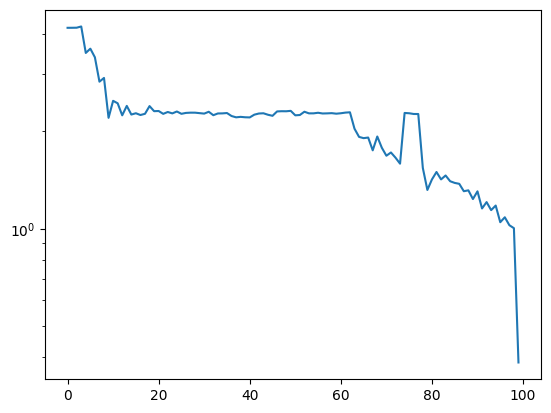

In [18]:
g = sns.lineplot(np.asarray(train_losses))
g.set_yscale('log')

In [19]:
with torch.no_grad():
    model_nn.eval()
    pred_nn = torch.round(model_nn(X_test_tensor)).squeeze(1).numpy().astype(int)
    report_nn = metrics.classification_report(
        y_test_tensor.squeeze(1).numpy().astype(int),
        pred_nn,
        output_dict=True,
    )

In [20]:
df_reports = util.concat_report_dicts_to_df({
    "logistic-regression": report_logistic,
    "cat-boost": report_cat,
    "nn-model": report_nn,
})

<Figure size 640x480 with 0 Axes>

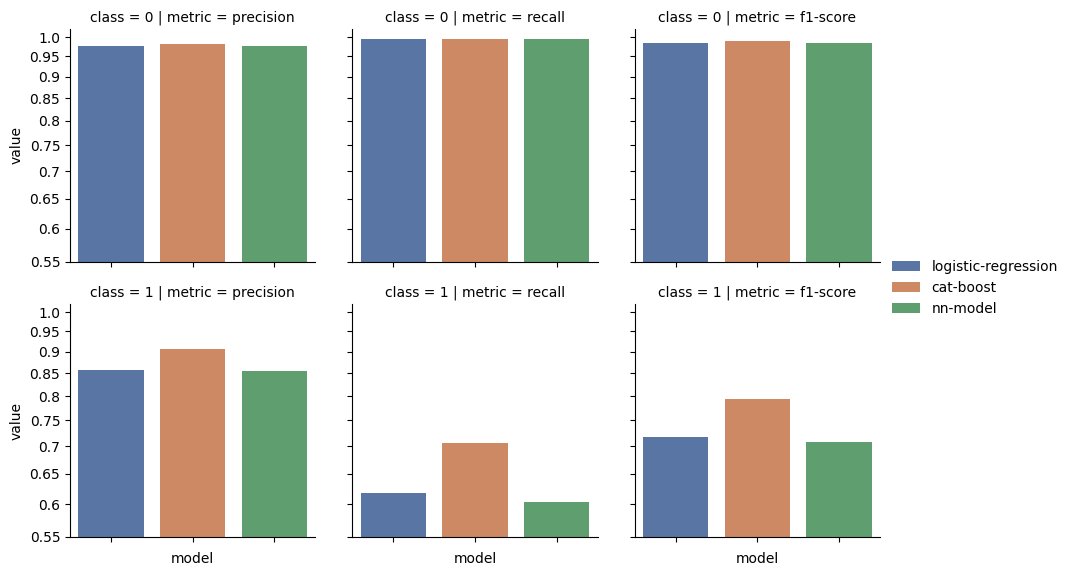

In [21]:
plt.tight_layout()
g = sns.FacetGrid(df_reports.to_pandas(), row="class", col="metric", sharey=True)
g.map_dataframe(
    sns.barplot,
    x="model",
    y="value",
    hue="model",
    palette="deep",
    legend=True,
).set(yscale="log")

g.set_xlabels()
g.set_xticklabels([])

max_val = 1.05
min_val = 0.55
g.set(
    yticks=np.arange(min_val, max_val, 0.05),
    yticklabels=[np.round(x, 2) for x in np.arange(min_val, max_val, 0.05)],
)
g.add_legend()

In [22]:
sorted(list(zip(df_features.columns, model_cat.feature_importances_)), key=lambda x: x[1], reverse=True)

[('query-match-diff-q75', 12.107761626142857),
 ('query-matches', 12.025210986135411),
 ('target-matches', 11.820862913636336),
 ('target-overlap-length', 11.310754886366308),
 ('query-match-diff-q90', 11.305038214083472),
 ('query-match-diff-q95', 11.094266624215443),
 ('query-match-diff-q98', 10.412127150411878),
 ('query-overlap-length', 10.363102907942643),
 ('diff-mean', 9.560874691065656)]

In [23]:
model_cat.save_model('../models/model-strict-large.cat')
model_cat_loaded = cb.CatBoostClassifier().load_model('../models/model-strict-large.cat')

In [25]:
report_cat

{'0': {'precision': 0.9825632083696599,
  'recall': 0.9955830388692579,
  'f1-score': 0.9890302764370338,
  'support': 1132.0},
 '1': {'precision': 0.9056603773584906,
  'recall': 0.7058823529411765,
  'f1-score': 0.7933884297520661,
  'support': 68.0},
 'accuracy': 0.9791666666666666,
 'macro avg': {'precision': 0.9441117928640752,
  'recall': 0.8507326959052173,
  'f1-score': 0.89120935309455,
  'support': 1200.0},
 'weighted avg': {'precision': 0.9782053812790271,
  'recall': 0.9791666666666666,
  'f1-score': 0.9779439051248856,
  'support': 1200.0}}